# Imports

In [1]:
from IPython.display import display
from tqdm import tqdm

# Setup Paths

In [2]:
from pathlib import Path
Path("/content").mkdir(parents=True, exist_ok=True)

# Install dependencies Part 1

In [3]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Counting objects: 100% (2658/2658), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 14652 (delta 2535), reused 2429 (delta 2429), pack-reused 11994 (from 1)
Receiving objects: 100% (14652/14652), 21.60 MiB | 30.05 MiB/s, done.
Resolving deltas: 100% (9923/9923), done.
/content/TotoroUI


In [4]:
!ls

folder_paths.py    node_helpers.py  totoro
latent_preview.py  nodes.py	    totoro_extras


# Install dependencies Part 2

In [5]:
!pip install -q torchsde einops diffusers accelerate xformers==0.0.27
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

The following additional packages will be installed:
  libaria2-0 libc-ares2 libssh2-1
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2 libssh2-1
0 upgraded, 4 newly installed, 0 to remove and 80 not upgraded.
Need to get 1551 kB of archives.
After this operation, 6235 kB of additional disk space will be used.

78Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 113807 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.15.0-1ubuntu0.5_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###.......................................................] 8Unpacking libc-ares2:amd64 (1.15.0-1ubuntu0.5) ...
7Progress: [ 12%] [######....................................................] 8Selecting previously unselected package libssh2-1:amd64.
Preparing to unpack .../libssh2-1_1.8.0-2.1ubuntu0.1_amd64.deb ...
7Progress: [ 18%] [##########.......

# Basic functionalities

In [6]:
import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Image generation function

In [7]:
# height of the generated image
height = 512
# width of the generated image
width = 512

# run the flux schnell code again with the resulting image generation as 1024x1024, so that 
# the t2i metric computation is on the same ground for all the t2i models

In [8]:
%%time
def image_inference(positive_prompt, steps, height, width):
    with torch.inference_mode():
        positive_prompt=positive_prompt
        width = width
        height = height
        seed = 42
        steps = steps
        sampler_name = "euler"
        scheduler = "simple"

        if seed == 0:
            seed = random.randint(0, 18446744073709551615)
        #print(seed)

        cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
        cond = [[cond, {"pooled_output": pooled}]]
        noise = RandomNoise.get_noise(seed)[0] 
        guider = BasicGuider.get_guider(unet, cond)[0]
        sampler = KSamplerSelect.get_sampler(sampler_name)[0]
        sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
        latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
        sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
        model_management.soft_empty_cache()
        decoded = VAEDecode.decode(vae, sample)[0].detach()
        #Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")
        return Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


# Read the prompt file

In [10]:
prompt_file_path = '' # add the path to the prompt file
with open(prompt_file_path) as f:
    prompts = [line.rstrip('\n') for line in f]

print('total number of prompts: ', len(prompts))

total number of prompts:  200


In [11]:
import time
generation_time = []
generated_image = []
count = 0
steps = 8

for prompt in tqdm(range(len(prompts))):
    count += 1
    print('Generating image number: ', count)
    start_time = time.time()
    generated_image.append(image_inference(prompts[prompt].split(' : ')[1], steps, width, height))
    end_time = time.time()
    generation_time.append(end_time - start_time)
    #print('time required: ', end_time - start_time)
    #if count == 1:
    #    break

  0%|          | 0/200 [00:00<?, ?it/s]

Generating image number:  1


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 1/200 [01:12<4:01:26, 72.79s/it]

Generating image number:  2


  0%|          | 0/8 [00:00<?, ?it/s]

  1%|          | 2/200 [02:35<4:19:02, 78.50s/it]

Generating image number:  3


  0%|          | 0/8 [00:00<?, ?it/s]

  2%|▏         | 3/200 [03:59<4:26:13, 81.08s/it]

Generating image number:  4


  0%|          | 0/8 [00:00<?, ?it/s]

  2%|▏         | 4/200 [05:23<4:28:42, 82.26s/it]

Generating image number:  5


  0%|          | 0/8 [00:00<?, ?it/s]

  2%|▎         | 5/200 [06:47<4:28:56, 82.75s/it]

Generating image number:  6


  0%|          | 0/8 [00:00<?, ?it/s]

  3%|▎         | 6/200 [08:10<4:28:37, 83.08s/it]

Generating image number:  7


  0%|          | 0/8 [00:00<?, ?it/s]

  4%|▎         | 7/200 [09:34<4:27:58, 83.31s/it]

Generating image number:  8


  0%|          | 0/8 [00:00<?, ?it/s]

  4%|▍         | 8/200 [10:58<4:27:04, 83.46s/it]

Generating image number:  9


  0%|          | 0/8 [00:00<?, ?it/s]

  4%|▍         | 9/200 [12:22<4:25:54, 83.53s/it]

Generating image number:  10


  0%|          | 0/8 [00:00<?, ?it/s]

  5%|▌         | 10/200 [13:45<4:24:01, 83.38s/it]

Generating image number:  11


  0%|          | 0/8 [00:00<?, ?it/s]

  6%|▌         | 11/200 [15:08<4:22:44, 83.41s/it]

Generating image number:  12


  0%|          | 0/8 [00:00<?, ?it/s]

  6%|▌         | 12/200 [16:32<4:21:43, 83.53s/it]

Generating image number:  13


  0%|          | 0/8 [00:00<?, ?it/s]

  6%|▋         | 13/200 [17:55<4:20:12, 83.49s/it]

Generating image number:  14


  0%|          | 0/8 [00:00<?, ?it/s]

  7%|▋         | 14/200 [19:19<4:19:10, 83.61s/it]

Generating image number:  15


  0%|          | 0/8 [00:00<?, ?it/s]

  8%|▊         | 15/200 [20:43<4:17:57, 83.66s/it]

Generating image number:  16


  0%|          | 0/8 [00:00<?, ?it/s]

  8%|▊         | 16/200 [22:07<4:16:28, 83.63s/it]

Generating image number:  17


  0%|          | 0/8 [00:00<?, ?it/s]

  8%|▊         | 17/200 [23:30<4:15:14, 83.69s/it]

Generating image number:  18


  0%|          | 0/8 [00:00<?, ?it/s]

  9%|▉         | 18/200 [24:54<4:14:00, 83.74s/it]

Generating image number:  19


  0%|          | 0/8 [00:00<?, ?it/s]

 10%|▉         | 19/200 [26:18<4:12:42, 83.77s/it]

Generating image number:  20


  0%|          | 0/8 [00:00<?, ?it/s]

 10%|█         | 20/200 [27:42<4:11:11, 83.73s/it]

Generating image number:  21


  0%|          | 0/8 [00:00<?, ?it/s]

 10%|█         | 21/200 [29:05<4:09:50, 83.75s/it]

Generating image number:  22


  0%|          | 0/8 [00:00<?, ?it/s]

 11%|█         | 22/200 [30:29<4:08:09, 83.65s/it]

Generating image number:  23


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▏        | 23/200 [31:52<4:06:24, 83.53s/it]

Generating image number:  24


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▏        | 24/200 [33:15<4:04:26, 83.33s/it]

Generating image number:  25


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 25/200 [34:39<4:03:22, 83.44s/it]

Generating image number:  26


  0%|          | 0/8 [00:00<?, ?it/s]

 13%|█▎        | 26/200 [36:02<4:01:57, 83.44s/it]

Generating image number:  27


  0%|          | 0/8 [00:00<?, ?it/s]

 14%|█▎        | 27/200 [37:25<4:00:26, 83.39s/it]

Generating image number:  28


  0%|          | 0/8 [00:00<?, ?it/s]

 14%|█▍        | 28/200 [38:49<3:59:25, 83.52s/it]

Generating image number:  29


  0%|          | 0/8 [00:00<?, ?it/s]

 14%|█▍        | 29/200 [40:14<3:58:41, 83.75s/it]

Generating image number:  30


  0%|          | 0/8 [00:00<?, ?it/s]

 15%|█▌        | 30/200 [41:37<3:57:19, 83.76s/it]

Generating image number:  31


  0%|          | 0/8 [00:00<?, ?it/s]

 16%|█▌        | 31/200 [43:01<3:55:41, 83.68s/it]

Generating image number:  32


  0%|          | 0/8 [00:00<?, ?it/s]

 16%|█▌        | 32/200 [44:24<3:54:12, 83.64s/it]

Generating image number:  33


  0%|          | 0/8 [00:00<?, ?it/s]

 16%|█▋        | 33/200 [45:50<3:54:30, 84.26s/it]

Generating image number:  34


  0%|          | 0/8 [00:00<?, ?it/s]

 17%|█▋        | 34/200 [47:15<3:53:50, 84.52s/it]

Generating image number:  35


  0%|          | 0/8 [00:00<?, ?it/s]

 18%|█▊        | 35/200 [48:40<3:52:29, 84.54s/it]

Generating image number:  36


  0%|          | 0/8 [00:00<?, ?it/s]

 18%|█▊        | 36/200 [50:04<3:51:01, 84.52s/it]

Generating image number:  37


  0%|          | 0/8 [00:00<?, ?it/s]

 18%|█▊        | 37/200 [51:29<3:49:27, 84.46s/it]

Generating image number:  38


  0%|          | 0/8 [00:00<?, ?it/s]

 19%|█▉        | 38/200 [52:53<3:47:55, 84.42s/it]

Generating image number:  39


  0%|          | 0/8 [00:00<?, ?it/s]

 20%|█▉        | 39/200 [54:17<3:46:25, 84.38s/it]

Generating image number:  40


  0%|          | 0/8 [00:00<?, ?it/s]

 20%|██        | 40/200 [55:41<3:44:36, 84.23s/it]

Generating image number:  41


  0%|          | 0/8 [00:00<?, ?it/s]

 20%|██        | 41/200 [57:05<3:43:06, 84.19s/it]

Generating image number:  42


  0%|          | 0/8 [00:00<?, ?it/s]

 21%|██        | 42/200 [58:29<3:41:38, 84.17s/it]

Generating image number:  43


  0%|          | 0/8 [00:00<?, ?it/s]

 22%|██▏       | 43/200 [59:54<3:40:19, 84.20s/it]

Generating image number:  44


  0%|          | 0/8 [00:00<?, ?it/s]

 22%|██▏       | 44/200 [1:01:18<3:38:55, 84.20s/it]

Generating image number:  45


  0%|          | 0/8 [00:00<?, ?it/s]

 22%|██▎       | 45/200 [1:02:42<3:37:22, 84.15s/it]

Generating image number:  46


  0%|          | 0/8 [00:00<?, ?it/s]

 23%|██▎       | 46/200 [1:04:06<3:35:44, 84.06s/it]

Generating image number:  47


  0%|          | 0/8 [00:00<?, ?it/s]

 24%|██▎       | 47/200 [1:05:30<3:34:20, 84.05s/it]

Generating image number:  48


  0%|          | 0/8 [00:00<?, ?it/s]

 24%|██▍       | 48/200 [1:06:54<3:32:53, 84.04s/it]

Generating image number:  49


  0%|          | 0/8 [00:00<?, ?it/s]

 24%|██▍       | 49/200 [1:08:17<3:31:13, 83.93s/it]

Generating image number:  50


  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 50/200 [1:09:41<3:29:26, 83.78s/it]

Generating image number:  51


  0%|          | 0/8 [00:00<?, ?it/s]

 26%|██▌       | 51/200 [1:11:05<3:28:13, 83.85s/it]

Generating image number:  52


  0%|          | 0/8 [00:00<?, ?it/s]

 26%|██▌       | 52/200 [1:12:29<3:26:54, 83.88s/it]

Generating image number:  53


  0%|          | 0/8 [00:00<?, ?it/s]

 26%|██▋       | 53/200 [1:13:52<3:25:12, 83.76s/it]

Generating image number:  54


  0%|          | 0/8 [00:00<?, ?it/s]

 27%|██▋       | 54/200 [1:15:17<3:24:11, 83.92s/it]

Generating image number:  55


  0%|          | 0/8 [00:00<?, ?it/s]

 28%|██▊       | 55/200 [1:16:41<3:22:58, 83.99s/it]

Generating image number:  56


  0%|          | 0/8 [00:00<?, ?it/s]

 28%|██▊       | 56/200 [1:18:04<3:21:10, 83.82s/it]

Generating image number:  57


  0%|          | 0/8 [00:00<?, ?it/s]

 28%|██▊       | 57/200 [1:19:29<3:20:33, 84.15s/it]

Generating image number:  58


  0%|          | 0/8 [00:00<?, ?it/s]

 29%|██▉       | 58/200 [1:20:53<3:19:04, 84.11s/it]

Generating image number:  59


  0%|          | 0/8 [00:00<?, ?it/s]

 30%|██▉       | 59/200 [1:22:17<3:17:51, 84.19s/it]

Generating image number:  60


  0%|          | 0/8 [00:00<?, ?it/s]

 30%|███       | 60/200 [1:23:42<3:16:24, 84.17s/it]

Generating image number:  61


  0%|          | 0/8 [00:00<?, ?it/s]

 30%|███       | 61/200 [1:25:06<3:15:00, 84.18s/it]

Generating image number:  62


  0%|          | 0/8 [00:00<?, ?it/s]

 31%|███       | 62/200 [1:26:30<3:13:28, 84.12s/it]

Generating image number:  63


  0%|          | 0/8 [00:00<?, ?it/s]

 32%|███▏      | 63/200 [1:27:54<3:11:56, 84.06s/it]

Generating image number:  64


  0%|          | 0/8 [00:00<?, ?it/s]

 32%|███▏      | 64/200 [1:29:18<3:10:24, 84.01s/it]

Generating image number:  65


  0%|          | 0/8 [00:00<?, ?it/s]

 32%|███▎      | 65/200 [1:30:42<3:09:22, 84.17s/it]

Generating image number:  66


  0%|          | 0/8 [00:00<?, ?it/s]

 33%|███▎      | 66/200 [1:32:06<3:08:06, 84.22s/it]

Generating image number:  67


  0%|          | 0/8 [00:00<?, ?it/s]

 34%|███▎      | 67/200 [1:33:31<3:06:48, 84.27s/it]

Generating image number:  68


  0%|          | 0/8 [00:00<?, ?it/s]

 34%|███▍      | 68/200 [1:34:55<3:05:28, 84.31s/it]

Generating image number:  69


  0%|          | 0/8 [00:00<?, ?it/s]

 34%|███▍      | 69/200 [1:36:19<3:03:38, 84.11s/it]

Generating image number:  70


  0%|          | 0/8 [00:00<?, ?it/s]

 35%|███▌      | 70/200 [1:37:42<3:01:47, 83.91s/it]

Generating image number:  71


  0%|          | 0/8 [00:00<?, ?it/s]

 36%|███▌      | 71/200 [1:39:06<3:00:02, 83.74s/it]

Generating image number:  72


  0%|          | 0/8 [00:00<?, ?it/s]

 36%|███▌      | 72/200 [1:40:30<2:58:53, 83.86s/it]

Generating image number:  73


  0%|          | 0/8 [00:00<?, ?it/s]

 36%|███▋      | 73/200 [1:41:53<2:57:11, 83.71s/it]

Generating image number:  74


  0%|          | 0/8 [00:00<?, ?it/s]

 37%|███▋      | 74/200 [1:43:17<2:55:55, 83.78s/it]

Generating image number:  75


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 75/200 [1:44:41<2:54:37, 83.82s/it]

Generating image number:  76


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 76/200 [1:46:04<2:52:58, 83.70s/it]

Generating image number:  77


  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 77/200 [1:47:29<2:51:53, 83.85s/it]

Generating image number:  78


  0%|          | 0/8 [00:00<?, ?it/s]

 39%|███▉      | 78/200 [1:48:52<2:50:23, 83.80s/it]

Generating image number:  79


  0%|          | 0/8 [00:00<?, ?it/s]

 40%|███▉      | 79/200 [1:50:16<2:48:53, 83.75s/it]

Generating image number:  80


  0%|          | 0/8 [00:00<?, ?it/s]

 40%|████      | 80/200 [1:51:40<2:47:32, 83.77s/it]

Generating image number:  81


  0%|          | 0/8 [00:00<?, ?it/s]

 40%|████      | 81/200 [1:53:03<2:46:05, 83.75s/it]

Generating image number:  82


  0%|          | 0/8 [00:00<?, ?it/s]

 41%|████      | 82/200 [1:54:27<2:44:33, 83.67s/it]

Generating image number:  83


  0%|          | 0/8 [00:00<?, ?it/s]

 42%|████▏     | 83/200 [1:55:50<2:43:03, 83.62s/it]

Generating image number:  84


  0%|          | 0/8 [00:00<?, ?it/s]

 42%|████▏     | 84/200 [1:57:14<2:41:33, 83.57s/it]

Generating image number:  85


  0%|          | 0/8 [00:00<?, ?it/s]

 42%|████▎     | 85/200 [1:58:37<2:40:02, 83.50s/it]

Generating image number:  86


  0%|          | 0/8 [00:00<?, ?it/s]

 43%|████▎     | 86/200 [2:00:01<2:38:33, 83.45s/it]

Generating image number:  87


  0%|          | 0/8 [00:00<?, ?it/s]

 44%|████▎     | 87/200 [2:01:23<2:36:45, 83.23s/it]

Generating image number:  88


  0%|          | 0/8 [00:00<?, ?it/s]

 44%|████▍     | 88/200 [2:02:47<2:35:28, 83.29s/it]

Generating image number:  89


  0%|          | 0/8 [00:00<?, ?it/s]

 44%|████▍     | 89/200 [2:04:10<2:34:04, 83.28s/it]

Generating image number:  90


  0%|          | 0/8 [00:00<?, ?it/s]

 45%|████▌     | 90/200 [2:05:33<2:32:40, 83.27s/it]

Generating image number:  91


  0%|          | 0/8 [00:00<?, ?it/s]

 46%|████▌     | 91/200 [2:06:57<2:31:21, 83.32s/it]

Generating image number:  92


  0%|          | 0/8 [00:00<?, ?it/s]

 46%|████▌     | 92/200 [2:08:20<2:29:49, 83.24s/it]

Generating image number:  93


  0%|          | 0/8 [00:00<?, ?it/s]

 46%|████▋     | 93/200 [2:09:43<2:28:25, 83.23s/it]

Generating image number:  94


  0%|          | 0/8 [00:00<?, ?it/s]

 47%|████▋     | 94/200 [2:11:06<2:26:52, 83.13s/it]

Generating image number:  95


  0%|          | 0/8 [00:00<?, ?it/s]

 48%|████▊     | 95/200 [2:12:28<2:25:06, 82.92s/it]

Generating image number:  96


  0%|          | 0/8 [00:00<?, ?it/s]

 48%|████▊     | 96/200 [2:13:51<2:23:45, 82.93s/it]

Generating image number:  97


  0%|          | 0/8 [00:00<?, ?it/s]

 48%|████▊     | 97/200 [2:15:14<2:22:28, 82.99s/it]

Generating image number:  98


  0%|          | 0/8 [00:00<?, ?it/s]

 49%|████▉     | 98/200 [2:16:38<2:21:18, 83.12s/it]

Generating image number:  99


  0%|          | 0/8 [00:00<?, ?it/s]

 50%|████▉     | 99/200 [2:18:01<2:20:09, 83.27s/it]

Generating image number:  100


  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 100/200 [2:19:24<2:18:35, 83.15s/it]

Generating image number:  101


  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 101/200 [2:20:47<2:17:11, 83.14s/it]

Generating image number:  102


  0%|          | 0/8 [00:00<?, ?it/s]

 51%|█████     | 102/200 [2:22:11<2:15:54, 83.21s/it]

Generating image number:  103


  0%|          | 0/8 [00:00<?, ?it/s]

 52%|█████▏    | 103/200 [2:23:33<2:14:10, 83.00s/it]

Generating image number:  104


  0%|          | 0/8 [00:00<?, ?it/s]

 52%|█████▏    | 104/200 [2:24:57<2:13:20, 83.34s/it]

Generating image number:  105


  0%|          | 0/8 [00:00<?, ?it/s]

 52%|█████▎    | 105/200 [2:26:21<2:12:05, 83.43s/it]

Generating image number:  106


  0%|          | 0/8 [00:00<?, ?it/s]

 53%|█████▎    | 106/200 [2:27:44<2:10:41, 83.42s/it]

Generating image number:  107


  0%|          | 0/8 [00:00<?, ?it/s]

 54%|█████▎    | 107/200 [2:29:08<2:09:26, 83.51s/it]

Generating image number:  108


  0%|          | 0/8 [00:00<?, ?it/s]

 54%|█████▍    | 108/200 [2:30:32<2:08:12, 83.61s/it]

Generating image number:  109


  0%|          | 0/8 [00:00<?, ?it/s]

 55%|█████▍    | 109/200 [2:31:56<2:06:54, 83.67s/it]

Generating image number:  110


  0%|          | 0/8 [00:00<?, ?it/s]

 55%|█████▌    | 110/200 [2:33:19<2:05:15, 83.51s/it]

Generating image number:  111


  0%|          | 0/8 [00:00<?, ?it/s]

 56%|█████▌    | 111/200 [2:34:42<2:03:52, 83.51s/it]

Generating image number:  112


  0%|          | 0/8 [00:00<?, ?it/s]

 56%|█████▌    | 112/200 [2:36:06<2:02:29, 83.52s/it]

Generating image number:  113


  0%|          | 0/8 [00:00<?, ?it/s]

 56%|█████▋    | 113/200 [2:37:30<2:01:17, 83.65s/it]

Generating image number:  114


  0%|          | 0/8 [00:00<?, ?it/s]

 57%|█████▋    | 114/200 [2:38:53<1:59:37, 83.46s/it]

Generating image number:  115


  0%|          | 0/8 [00:00<?, ?it/s]

 57%|█████▊    | 115/200 [2:40:17<1:58:25, 83.59s/it]

Generating image number:  116


  0%|          | 0/8 [00:00<?, ?it/s]

 58%|█████▊    | 116/200 [2:41:40<1:56:59, 83.56s/it]

Generating image number:  117


  0%|          | 0/8 [00:00<?, ?it/s]

 58%|█████▊    | 117/200 [2:43:04<1:55:27, 83.47s/it]

Generating image number:  118


  0%|          | 0/8 [00:00<?, ?it/s]

 59%|█████▉    | 118/200 [2:44:27<1:54:03, 83.46s/it]

Generating image number:  119


  0%|          | 0/8 [00:00<?, ?it/s]

 60%|█████▉    | 119/200 [2:45:50<1:52:32, 83.36s/it]

Generating image number:  120


  0%|          | 0/8 [00:00<?, ?it/s]

 60%|██████    | 120/200 [2:47:13<1:51:01, 83.27s/it]

Generating image number:  121


  0%|          | 0/8 [00:00<?, ?it/s]

 60%|██████    | 121/200 [2:48:36<1:49:30, 83.18s/it]

Generating image number:  122


  0%|          | 0/8 [00:00<?, ?it/s]

 61%|██████    | 122/200 [2:49:59<1:48:10, 83.21s/it]

Generating image number:  123


  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▏   | 123/200 [2:51:23<1:46:53, 83.29s/it]

Generating image number:  124


  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▏   | 124/200 [2:52:47<1:45:38, 83.41s/it]

Generating image number:  125


  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 125/200 [2:54:10<1:44:19, 83.46s/it]

Generating image number:  126


  0%|          | 0/8 [00:00<?, ?it/s]

 63%|██████▎   | 126/200 [2:55:35<1:43:14, 83.71s/it]

Generating image number:  127


  0%|          | 0/8 [00:00<?, ?it/s]

 64%|██████▎   | 127/200 [2:56:58<1:41:45, 83.64s/it]

Generating image number:  128


  0%|          | 0/8 [00:00<?, ?it/s]

 64%|██████▍   | 128/200 [2:58:21<1:40:11, 83.50s/it]

Generating image number:  129


  0%|          | 0/8 [00:00<?, ?it/s]

 64%|██████▍   | 129/200 [2:59:45<1:38:55, 83.60s/it]

Generating image number:  130


  0%|          | 0/8 [00:00<?, ?it/s]

 65%|██████▌   | 130/200 [3:01:09<1:37:34, 83.63s/it]

Generating image number:  131


  0%|          | 0/8 [00:00<?, ?it/s]

 66%|██████▌   | 131/200 [3:02:32<1:35:59, 83.47s/it]

Generating image number:  132


  0%|          | 0/8 [00:00<?, ?it/s]

 66%|██████▌   | 132/200 [3:03:55<1:34:27, 83.35s/it]

Generating image number:  133


  0%|          | 0/8 [00:00<?, ?it/s]

 66%|██████▋   | 133/200 [3:05:18<1:33:07, 83.40s/it]

Generating image number:  134


  0%|          | 0/8 [00:00<?, ?it/s]

 67%|██████▋   | 134/200 [3:06:42<1:31:45, 83.42s/it]

Generating image number:  135


  0%|          | 0/8 [00:00<?, ?it/s]

 68%|██████▊   | 135/200 [3:08:05<1:30:20, 83.40s/it]

Generating image number:  136


  0%|          | 0/8 [00:00<?, ?it/s]

 68%|██████▊   | 136/200 [3:09:29<1:28:57, 83.40s/it]

Generating image number:  137


  0%|          | 0/8 [00:00<?, ?it/s]

 68%|██████▊   | 137/200 [3:10:52<1:27:30, 83.34s/it]

Generating image number:  138


  0%|          | 0/8 [00:00<?, ?it/s]

 69%|██████▉   | 138/200 [3:12:15<1:26:02, 83.27s/it]

Generating image number:  139


  0%|          | 0/8 [00:00<?, ?it/s]

 70%|██████▉   | 139/200 [3:13:38<1:24:30, 83.13s/it]

Generating image number:  140


  0%|          | 0/8 [00:00<?, ?it/s]

 70%|███████   | 140/200 [3:15:01<1:23:13, 83.23s/it]

Generating image number:  141


  0%|          | 0/8 [00:00<?, ?it/s]

 70%|███████   | 141/200 [3:16:24<1:21:50, 83.23s/it]

Generating image number:  142


  0%|          | 0/8 [00:00<?, ?it/s]

 71%|███████   | 142/200 [3:17:48<1:20:30, 83.29s/it]

Generating image number:  143


  0%|          | 0/8 [00:00<?, ?it/s]

 72%|███████▏  | 143/200 [3:19:11<1:19:06, 83.26s/it]

Generating image number:  144


  0%|          | 0/8 [00:00<?, ?it/s]

 72%|███████▏  | 144/200 [3:20:34<1:17:36, 83.14s/it]

Generating image number:  145


  0%|          | 0/8 [00:00<?, ?it/s]

 72%|███████▎  | 145/200 [3:21:57<1:16:13, 83.16s/it]

Generating image number:  146


  0%|          | 0/8 [00:00<?, ?it/s]

 73%|███████▎  | 146/200 [3:23:20<1:14:52, 83.20s/it]

Generating image number:  147


  0%|          | 0/8 [00:00<?, ?it/s]

 74%|███████▎  | 147/200 [3:24:43<1:13:24, 83.11s/it]

Generating image number:  148


  0%|          | 0/8 [00:00<?, ?it/s]

 74%|███████▍  | 148/200 [3:26:07<1:12:03, 83.15s/it]

Generating image number:  149


  0%|          | 0/8 [00:00<?, ?it/s]

 74%|███████▍  | 149/200 [3:27:30<1:10:44, 83.23s/it]

Generating image number:  150


  0%|          | 0/8 [00:00<?, ?it/s]

 75%|███████▌  | 150/200 [3:28:53<1:09:24, 83.29s/it]

Generating image number:  151


  0%|          | 0/8 [00:00<?, ?it/s]

 76%|███████▌  | 151/200 [3:30:17<1:08:00, 83.28s/it]

Generating image number:  152


  0%|          | 0/8 [00:00<?, ?it/s]

 76%|███████▌  | 152/200 [3:31:40<1:06:33, 83.19s/it]

Generating image number:  153


  0%|          | 0/8 [00:00<?, ?it/s]

 76%|███████▋  | 153/200 [3:33:03<1:05:08, 83.16s/it]

Generating image number:  154


  0%|          | 0/8 [00:00<?, ?it/s]

 77%|███████▋  | 154/200 [3:34:26<1:03:44, 83.14s/it]

Generating image number:  155


  0%|          | 0/8 [00:00<?, ?it/s]

 78%|███████▊  | 155/200 [3:35:49<1:02:19, 83.10s/it]

Generating image number:  156


  0%|          | 0/8 [00:00<?, ?it/s]

 78%|███████▊  | 156/200 [3:37:12<1:00:57, 83.13s/it]

Generating image number:  157


  0%|          | 0/8 [00:00<?, ?it/s]

 78%|███████▊  | 157/200 [3:38:35<59:31, 83.07s/it]  

Generating image number:  158


  0%|          | 0/8 [00:00<?, ?it/s]

 79%|███████▉  | 158/200 [3:39:58<58:10, 83.10s/it]

Generating image number:  159


  0%|          | 0/8 [00:00<?, ?it/s]

 80%|███████▉  | 159/200 [3:41:22<56:52, 83.23s/it]

Generating image number:  160


  0%|          | 0/8 [00:00<?, ?it/s]

 80%|████████  | 160/200 [3:42:46<55:45, 83.64s/it]

Generating image number:  161


  0%|          | 0/8 [00:00<?, ?it/s]

 80%|████████  | 161/200 [3:44:10<54:28, 83.81s/it]

Generating image number:  162


  0%|          | 0/8 [00:00<?, ?it/s]

 81%|████████  | 162/200 [3:45:35<53:08, 83.92s/it]

Generating image number:  163


  0%|          | 0/8 [00:00<?, ?it/s]

 82%|████████▏ | 163/200 [3:46:59<51:45, 83.93s/it]

Generating image number:  164


  0%|          | 0/8 [00:00<?, ?it/s]

 82%|████████▏ | 164/200 [3:48:23<50:23, 83.98s/it]

Generating image number:  165


  0%|          | 0/8 [00:00<?, ?it/s]

 82%|████████▎ | 165/200 [3:49:47<49:03, 84.11s/it]

Generating image number:  166


  0%|          | 0/8 [00:00<?, ?it/s]

 83%|████████▎ | 166/200 [3:51:11<47:39, 84.11s/it]

Generating image number:  167


  0%|          | 0/8 [00:00<?, ?it/s]

 84%|████████▎ | 167/200 [3:52:35<46:14, 84.07s/it]

Generating image number:  168


  0%|          | 0/8 [00:00<?, ?it/s]

 84%|████████▍ | 168/200 [3:53:59<44:50, 84.08s/it]

Generating image number:  169


  0%|          | 0/8 [00:00<?, ?it/s]

 84%|████████▍ | 169/200 [3:55:23<43:26, 84.09s/it]

Generating image number:  170


  0%|          | 0/8 [00:00<?, ?it/s]

 85%|████████▌ | 170/200 [3:56:47<42:02, 84.08s/it]

Generating image number:  171


  0%|          | 0/8 [00:00<?, ?it/s]

 86%|████████▌ | 171/200 [3:58:11<40:38, 84.07s/it]

Generating image number:  172


  0%|          | 0/8 [00:00<?, ?it/s]

 86%|████████▌ | 172/200 [3:59:35<39:09, 83.90s/it]

Generating image number:  173


  0%|          | 0/8 [00:00<?, ?it/s]

 86%|████████▋ | 173/200 [4:00:59<37:46, 83.95s/it]

Generating image number:  174


  0%|          | 0/8 [00:00<?, ?it/s]

 87%|████████▋ | 174/200 [4:02:23<36:22, 83.96s/it]

Generating image number:  175


  0%|          | 0/8 [00:00<?, ?it/s]

 88%|████████▊ | 175/200 [4:03:48<35:03, 84.14s/it]

Generating image number:  176


  0%|          | 0/8 [00:00<?, ?it/s]

 88%|████████▊ | 176/200 [4:05:12<33:38, 84.09s/it]

Generating image number:  177


  0%|          | 0/8 [00:00<?, ?it/s]

 88%|████████▊ | 177/200 [4:06:35<32:11, 83.96s/it]

Generating image number:  178


  0%|          | 0/8 [00:00<?, ?it/s]

 89%|████████▉ | 178/200 [4:07:59<30:47, 83.98s/it]

Generating image number:  179


  0%|          | 0/8 [00:00<?, ?it/s]

 90%|████████▉ | 179/200 [4:09:24<29:25, 84.09s/it]

Generating image number:  180


  0%|          | 0/8 [00:00<?, ?it/s]

 90%|█████████ | 180/200 [4:10:48<28:04, 84.23s/it]

Generating image number:  181


  0%|          | 0/8 [00:00<?, ?it/s]

 90%|█████████ | 181/200 [4:12:12<26:38, 84.13s/it]

Generating image number:  182


  0%|          | 0/8 [00:00<?, ?it/s]

 91%|█████████ | 182/200 [4:13:36<25:11, 83.99s/it]

Generating image number:  183


  0%|          | 0/8 [00:00<?, ?it/s]

 92%|█████████▏| 183/200 [4:15:00<23:49, 84.06s/it]

Generating image number:  184


  0%|          | 0/8 [00:00<?, ?it/s]

 92%|█████████▏| 184/200 [4:16:24<22:25, 84.11s/it]

Generating image number:  185


  0%|          | 0/8 [00:00<?, ?it/s]

 92%|█████████▎| 185/200 [4:17:48<21:02, 84.15s/it]

Generating image number:  186


  0%|          | 0/8 [00:00<?, ?it/s]

 93%|█████████▎| 186/200 [4:19:12<19:37, 84.07s/it]

Generating image number:  187


  0%|          | 0/8 [00:00<?, ?it/s]

 94%|█████████▎| 187/200 [4:20:36<18:12, 84.00s/it]

Generating image number:  188


  0%|          | 0/8 [00:00<?, ?it/s]

 94%|█████████▍| 188/200 [4:22:00<16:47, 83.98s/it]

Generating image number:  189


  0%|          | 0/8 [00:00<?, ?it/s]

 94%|█████████▍| 189/200 [4:23:24<15:23, 83.99s/it]

Generating image number:  190


  0%|          | 0/8 [00:00<?, ?it/s]

 95%|█████████▌| 190/200 [4:24:48<13:58, 83.85s/it]

Generating image number:  191


  0%|          | 0/8 [00:00<?, ?it/s]

 96%|█████████▌| 191/200 [4:26:12<12:35, 83.94s/it]

Generating image number:  192


  0%|          | 0/8 [00:00<?, ?it/s]

 96%|█████████▌| 192/200 [4:27:36<11:11, 83.95s/it]

Generating image number:  193


  0%|          | 0/8 [00:00<?, ?it/s]

 96%|█████████▋| 193/200 [4:28:59<09:47, 83.87s/it]

Generating image number:  194


  0%|          | 0/8 [00:00<?, ?it/s]

 97%|█████████▋| 194/200 [4:30:23<08:23, 83.88s/it]

Generating image number:  195


  0%|          | 0/8 [00:00<?, ?it/s]

 98%|█████████▊| 195/200 [4:31:48<07:00, 84.02s/it]

Generating image number:  196


  0%|          | 0/8 [00:00<?, ?it/s]

 98%|█████████▊| 196/200 [4:33:12<05:35, 83.98s/it]

Generating image number:  197


  0%|          | 0/8 [00:00<?, ?it/s]

 98%|█████████▊| 197/200 [4:34:35<04:11, 83.97s/it]

Generating image number:  198


  0%|          | 0/8 [00:00<?, ?it/s]

 99%|█████████▉| 198/200 [4:36:00<02:48, 84.20s/it]

Generating image number:  199


  0%|          | 0/8 [00:00<?, ?it/s]

100%|█████████▉| 199/200 [4:37:24<01:24, 84.03s/it]

Generating image number:  200


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 200/200 [4:38:49<00:00, 83.65s/it]


# Visualize the time needed to generate the image

Text(0.5, 1.0, 'time needed to generate images in seconds')

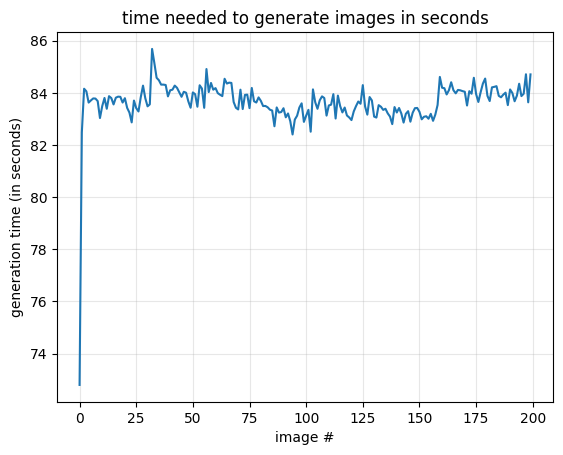

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(len(generation_time)), generation_time)
plt.grid(alpha=0.3)
plt.xlabel('image #')
plt.ylabel('generation time (in seconds)')
plt.title('time needed to generate images in seconds')

# Save the generated image along with the prompts and the time needed for the generation as a pickle file

In [14]:
# save the prompts, the time required and the generated images as a list of list (each entry in the main list will be a list of three entities -> prompt, time, generated image)
import pickle

generated_image_file_path = '' # declare the file path to save the generated images as pkl file
generated_time_path = '' # declare the file path to save the time sheet for image generation as a pkl file

with open(generated_image_file_path, 'wb') as f:
    pickle.dump(generated_image, f)

with open(generated_time_path, 'wb') as f:
    pickle.dump(generation_time, f)

In [18]:
#kaggle kernels output crischir/testing-flux1-flux-1-dev -p /kaggle/working/

In [19]:
#reference:
#https://gist.github.com/AmericanPresidentJimmyCarter/873985638e1f3541ba8b00137e7dacd9
#https://www.kaggle.com/code/crischir/testing-flux1-flux-1-dev